<a href="https://colab.research.google.com/github/fabiano182/AMC/blob/main/AMC_MIMO_Canal_Real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt


hf = h5py.File('/content/drive/MyDrive/TCC_COLAB/Datasets/UMa_6GHz_BS_ULA_16_UE_ULA_16.h5','r')

In [2]:
hfd = list([])
for i,ds in enumerate(hf.keys()):
  hfd.append(hf[ds][:,:])
hd = np.array(hfd)

In [3]:
print(hd.dtype)
print(hd.shape)

[('real', '<f8'), ('imag', '<f8')]
(50000, 16, 16)


In [4]:
def awgn(snr, nRx):
  EbNo = snr
  L = 128
  var = np.sqrt(1/(10**(EbNo/10))) 
  w = (np.random.normal(0,var,(1,nRx,L)) + 1j*np.random.normal(0,var,(1,nRx,L)))
  return w

In [5]:
def psk_mod(M ,L):
  m = np.arange(0,M)
  if (M==2):
    constellation = np.cos(m/M*2*np.pi)
  elif (M==4):
    constellation = np.exp(1j*np.pi/4)*(np.cos(m/M*2*np.pi) + 1j*np.sin(m/M*2*np.pi))
  else :
    constellation = np.cos(m/M*2*np.pi) + 1j*np.sin(m/M*2*np.pi)
  in_syms = np.random.randint(low=0, high = M, size=L)
  s = constellation[in_syms]
  return s

def qam_mod(M,L):
  n = np.arange(0,M)
  a = np.asarray([x^(x>>1) for x in n])
  D = np.sqrt(M).astype(int)
  a = np.reshape(a,(D,D))
        
  nGray=np.reshape(a,(M)) 

  (x,y)=np.divmod(nGray,D) 
  Ax=2*x+1-D
  Ay=2*y+1-D 

  constellation = Ax + 1j*Ay

  in_syms = np.random.randint(low=0, high = M, size=L)
  s = constellation[in_syms]
  return s

In [6]:
def rayChan(nTx,nRx):
  H = np.array(hd[np.random.randint(0,50000),:nTx,:nRx].tolist()).astype(float)
  
  # if (nTx == 2 and nRx == 1):
  #   Hl = np.array([H[0][0][0] + 1j*H[0][0][1], H[1][0][0] + 1j*H[1][0][1]])

  # if (nTx == 2 and nRx == 2):
  #   Hl = np.array([[H[0][0][0] + 1j*H[0][0][1], H[1][0][0] + 1j*H[1][0][1]],
  #                 [ H[0][1][0] + 1j*H[0][1][1], H[1][1][0] + 1j*H[1][1][1]]])

  h_chann = []
  for t in range(nTx):
    htr = []
    for r in range(nRx):
      htr = np.append(htr,[H[t][r][0] + 1j*H[t][r][1]])

    h_chann.append(htr)

  return np.array(h_chann)

h = rayChan(2, 4)
print(h)

[[ 4.26276705e-07+1.78896738e-09j -1.02384162e-06-1.01385383e-06j
  -4.94841456e-07+4.67338239e-07j -4.81278849e-07-7.29993640e-08j]
 [ 4.38317856e-07-6.56181363e-08j -1.22441991e-06-8.02186789e-07j
  -4.21488070e-07+5.93832188e-07j -4.96869638e-07+7.88999680e-08j]]


In [7]:
def mimo(x, nTx, nRx, snr):
  x = np.tile(x,(nTx,1))
  H = rayChan(nTx,nRx)
  H = np.ones((nTx,nRx))
  w = awgn(snr, nRx)

  if nRx >= nTx:
    y = np.sum((np.dot(H.T,x) + w)/nRx, axis=1)
  else:
    y = np.sum((H*x + w)/nRx, axis=1)

  return np.reshape(np.array([[y.real],[y.imag]]),[1,2,128])

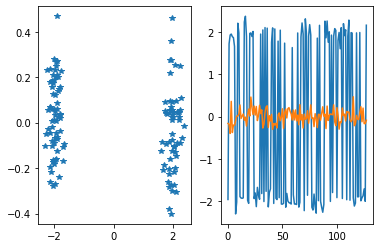

In [8]:
s = mimo(psk_mod(2,128), 2, 4 ,10)

sI = s[0,0,:]; sQ = s[0,1,:]
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
ax1.plot(sI, sQ,'*')
ax2.plot(sI)
ax2.plot(sQ)
plt.show()

In [55]:
nTx = 4; nRx = 4; L = 128
snrs = list(range(-20,25,5))
ntest = 500
t = ntest*len(snrs)
data_bpsk = np.zeros([t,2,L])
data_qpsk = np.zeros([t,2,L])
data_16qam = np.zeros([t,2,L])
data_8psk = np.zeros([t,2,L])
data_64qam = np.zeros([t,2,L])

lbl_bpsk = np.zeros([t,2])
lbl_qpsk = np.zeros([t,2])
lbl_8psk = np.zeros([t,2])
lbl_16qam = np.zeros([t,2])
lbl_64qam = np.zeros([t,2])


[ 0. 20.]


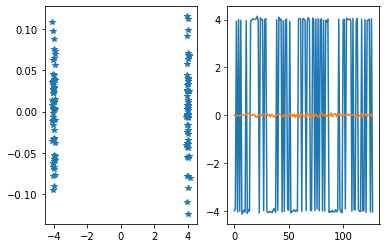

[ 1. 20.]


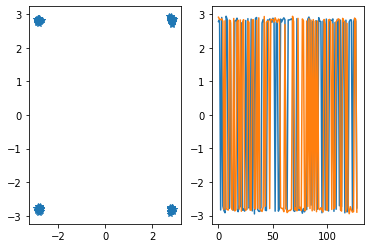

[ 2. 20.]


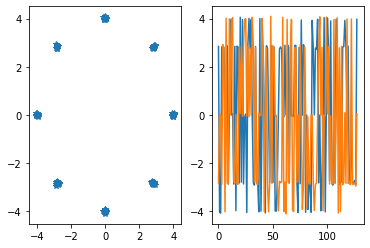

[ 3. 20.]


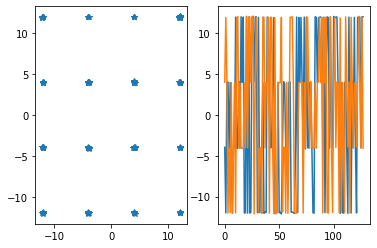

[ 4. 20.]


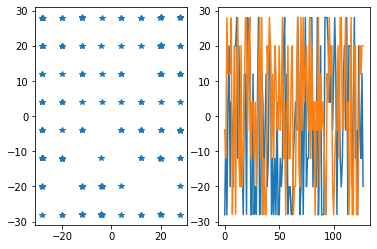

In [56]:
for i,snr in enumerate(snrs):
  for j in range(ntest):
    data_bpsk[i*ntest+j,:,:] = mimo(psk_mod(2,L), nTx, nRx ,snr)
    lbl_bpsk[i*ntest+j,:] = [0, snr]
  
  for j in range(ntest):
    data_qpsk[i*ntest+j,:,:] = mimo(psk_mod(4,L), nTx, nRx ,snr)
    lbl_qpsk[i*ntest+j,:] = [1, snr]

  for j in range(ntest):
    data_8psk[i*ntest+j,:,:] = mimo(psk_mod(8,L), nTx, nRx ,snr)
    lbl_8psk[i*ntest+j,:] = [2, snr]
  
  for j in range(ntest):
    data_16qam[i*ntest+j,:,:] = mimo(qam_mod(16,L), nTx, nRx ,snr)
    lbl_16qam[i*ntest+j,:] = [3, snr]
  
  for j in range(ntest):
    data_64qam[i*ntest+j,:,:] = mimo(qam_mod(64,L), nTx, nRx ,snr)
    lbl_64qam[i*ntest+j,:] = [4, snr]

print(lbl_bpsk[-1,:])
sI = data_bpsk[-1,0,:]; sQ = data_bpsk[-1,1,:]
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
ax1.plot(sI, sQ,'*')
ax2.plot(sI)
ax2.plot(sQ)
plt.show()

print(lbl_qpsk[-1,:])
sI = data_qpsk[-1,0,:]; sQ = data_qpsk[-1,1,:]
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
ax1.plot(sI, sQ,'*')
ax2.plot(sI)
ax2.plot(sQ)
plt.show()

print(lbl_8psk[-1,:])
sI = data_8psk[-1,0,:]; sQ = data_8psk[-1,1,:]
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
ax1.plot(sI, sQ,'*')
ax2.plot(sI)
ax2.plot(sQ)
plt.show()

print(lbl_16qam[-1,:])
sI = data_16qam[-1,0,:]; sQ = data_16qam[-1,1,:]
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
ax1.plot(sI, sQ,'*')
ax2.plot(sI)
ax2.plot(sQ)
plt.show()

print(lbl_64qam[-1,:])
sI = data_64qam[-1,0,:]; sQ = data_64qam[-1,1,:]
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
ax1.plot(sI, sQ,'*')
ax2.plot(sI)
ax2.plot(sQ)
plt.show()

In [57]:
data = np.vstack((data_bpsk, data_qpsk, data_8psk, data_16qam, data_64qam))
label = np.vstack((lbl_bpsk, lbl_qpsk, lbl_8psk, lbl_16qam, lbl_64qam))[:,0].astype(int)
snrs = np.vstack((lbl_bpsk, lbl_qpsk, lbl_8psk, lbl_16qam, lbl_64qam))[:,1].astype(int)
print(data.shape)
print(label.shape)
print(snrs.shape)

(22500, 2, 128)
(22500,)
(22500,)


In [58]:
def one_hot_encode(x, n_classes):
  return np.eye(n_classes)[x]

n_classes = 5
lbl_onehot = one_hot_encode(label.T, n_classes)

Xt = data
Yt = lbl_onehot

print(Xt.shape)
print(Yt.shape)

(22500, 2, 128)
(22500, 5)


In [59]:
idx = list(range(lbl_onehot.shape[0]))
np.random.shuffle(idx)

data = data[idx,:,:]
lbl_onehot = lbl_onehot[idx,:]
snrs = snrs[idx]

split = 0.7 #70% Treino 30% Validação
total = data.shape[0] #30k amostras
sp = int(split*total)

X_test = data[:sp,:,:]
Y_test = lbl_onehot[0:sp,:]

X_val = data[-(total-sp):,:,:]
Y_val = lbl_onehot[-(total-sp):,:]

print(X_test.shape, X_val.shape)
print(Y_test.shape,Y_val.shape)
#print(snrs.shape)

(15749, 2, 128) (6751, 2, 128)
(15749, 5) (6751, 5)


In [60]:
import keras
from keras.layers import *
from keras.models import Model
from keras.activations import *
from keras.callbacks import ModelCheckpoint, EarlyStopping

def cnn2():
  dr = 0.25

  input = Input((2, 128, 1))
  x = ZeroPadding2D((0,2))(input)                               
  x = Conv2D(128, (2, 3))(x)
  x = ReLU()(x)                                   
  x = Dropout(dr)(x)

  x = ZeroPadding2D((0,2))(x) 
  x = Conv2D(16, (1, 3))(x)   
  x = ReLU()(x)
  x = Dropout(dr)(x)

  x = Flatten()(x)
  x = Dense(128)(x)
  x = ReLU()(x)
  x = Dropout(dr)(x)


  output = Dense(n_classes, activation='softmax')(x)      #Camada de saida
  model = Model(inputs=input, outputs=output)
  #model.summary()
  return model

In [61]:
%%time
model = cnn2()
opt = keras.optimizers.Adam(0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

history = model.fit(X_test,Y_test,
                    batch_size=256,
                    epochs=15,
                    verbose=1,
                    validation_data=(X_val,Y_val),
                    callbacks=[EarlyStopping(monitor='val_loss', verbose=1, patience=3)])

Epoch 1/15
62/62 [==============================] - 15s 227ms/step - loss: 1.5918 - categorical_accuracy: 0.2250 - val_loss: 0.8803 - val_categorical_accuracy: 0.5712
Epoch 2/15
62/62 [==============================] - 12s 199ms/step - loss: 0.7625 - categorical_accuracy: 0.6197 - val_loss: 0.3539 - val_categorical_accuracy: 0.8365
Epoch 3/15
62/62 [==============================] - 13s 208ms/step - loss: 0.3826 - categorical_accuracy: 0.7879 - val_loss: 0.2994 - val_categorical_accuracy: 0.8428
Epoch 4/15
62/62 [==============================] - 13s 210ms/step - loss: 0.3205 - categorical_accuracy: 0.8186 - val_loss: 0.2730 - val_categorical_accuracy: 0.8888
Epoch 5/15
62/62 [==============================] - 12s 196ms/step - loss: 0.2892 - categorical_accuracy: 0.8531 - val_loss: 0.2313 - val_categorical_accuracy: 0.9039
Epoch 6/15
62/62 [==============================] - 14s 222ms/step - loss: 0.2479 - categorical_accuracy: 0.8914 - val_loss: 0.2297 - val_categorical_accuracy: 0.888

In [62]:
#nTx = 2; nRx = 1; L = 128
snrs = list(range(-20,25,5))
ntest = 50
t = ntest*len(snrs)
data_bpsk = np.zeros([t,2,L])
data_qpsk = np.zeros([t,2,L])
data_8psk = np.zeros([t,2,L])
data_16qam = np.zeros([t,2,L])
data_64qam = np.zeros([t,2,L])

lbl_bpsk = np.zeros([t,2])
lbl_qpsk = np.zeros([t,2])
lbl_8psk = np.zeros([t,2])
lbl_16qam = np.zeros([t,2])
lbl_64qam = np.zeros([t,2])

for i,snr in enumerate(snrs):
  for j in range(ntest):
    data_bpsk[i*ntest+j,:,:] = mimo(psk_mod(2,128), nTx, nRx ,snr)
    lbl_bpsk[i*ntest+j,:] = [0, snr]
  
  for j in range(ntest):
    data_qpsk[i*ntest+j,:,:] = mimo(psk_mod(4,128), nTx, nRx ,snr)
    lbl_qpsk[i*ntest+j,:] = [1, snr]

  for j in range(ntest):
    data_8psk[i*ntest+j,:,:] = mimo(psk_mod(8,128), nTx, nRx ,snr)
    lbl_8psk[i*ntest+j,:] = [2, snr]
  
  for j in range(ntest):
    data_16qam[i*ntest+j,:,:] = mimo(qam_mod(16,128), nTx, nRx ,snr)
    lbl_16qam[i*ntest+j,:] = [3, snr]
  
  for j in range(ntest):
    data_64qam[i*ntest+j,:,:] = mimo(qam_mod(64,128), nTx, nRx ,snr)
    lbl_64qam[i*ntest+j,:] = [4, snr]

test_data = np.vstack((data_bpsk, data_qpsk, data_8psk, data_16qam, data_64qam))
lbl = np.vstack((lbl_bpsk, lbl_qpsk, lbl_8psk, lbl_16qam, lbl_64qam))[:,0].astype(int)
test_lbls = one_hot_encode(lbl.T, n_classes)
test_snrs = np.vstack((lbl_bpsk, lbl_qpsk, lbl_8psk, lbl_16qam, lbl_64qam))[:,1].astype(int)
print(test_data.shape)
print(test_lbls.shape)
print(test_snrs.shape)

(2250, 2, 128)
(2250, 5)
(2250,)


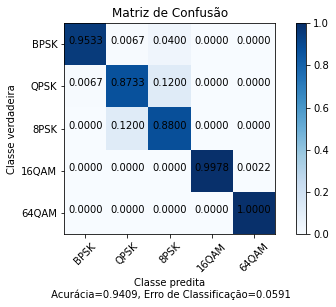

In [63]:
# Definição da função para plotar a CM
def plot_confusion_matrix(cm, target_names, title='Confusion matrix'):
  """"
  Baseada na biblioteca ScikitLearn
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

  """

  accuracy = np.trace(cm) / float(np.sum(cm)) # acuracia
  misclass = 1 - accuracy                     # erro de classificacao

  cmap = plt.get_cmap('Blues') #Cor de fundo, no caso niveis azul

  # gera a figura da matriz de confusao
  plt.figure()
  im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  # gera as legendas com um angulo de 45 graus
  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

  # gera a escrita no interior dos quadrados
  for i in range(0, cm.shape[0]):
    for j in range(0, cm.shape[1]):
      plt.text(j, i, "{:0.4f}".format(cm[i, j]), horizontalalignment="center", color="black")

  plt.tight_layout()
  plt.ylabel('Classe verdadeira')
  plt.xlabel('Classe predita\n Acurácia={:0.4f}, Erro de Classificação={:0.4f}'.format(accuracy, misclass))
  #plt.show()
# fim plot_confusion_matrix

# Matriz de Confusao de todo o dataset
X = test_data       # X sao os dados          
Y = test_lbls   # Y sao as labels
#y_pred = model.predict_classes(X_test, batch_size=batch_size)
y_pred = np.argmax(model.predict(X, batch_size=128), axis=1) #np.argmax pois model.predict_class vai ser removido do TF

classes =  ['BPSK', 'QPSK', '8PSK', '16QAM','64QAM']           # classes ou target_names
confmatrix = np.zeros([len(classes),len(classes)])      # Matriz de confusao
confmatrix_norm = np.zeros([len(classes),len(classes)]) # Matriz de confusao normalizada
for i in range(0,y_pred.shape[0]):
  j = list(Y[i,:]).index(1)
  k = y_pred[i]
  confmatrix[j,k] = confmatrix[j,k] + 1

for i in range(0,len(classes)):
  confmatrix_norm[i,:] = confmatrix[i,:] / np.sum(confmatrix[i,:])

plot_confusion_matrix(confmatrix_norm,classes,"Matriz de Confusão")

plt.savefig(f"/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO_Canal_Real/{nTx}x{nRx}/allsnrs.png", dpi=120, bbox_inches="tight")

plt.show()

<Figure size 432x288 with 0 Axes>

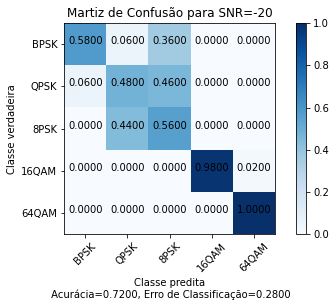

<Figure size 432x288 with 0 Axes>

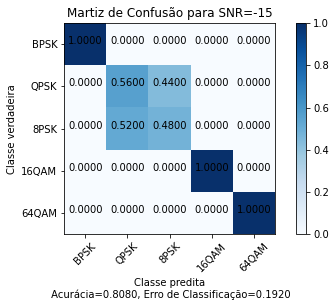

<Figure size 432x288 with 0 Axes>

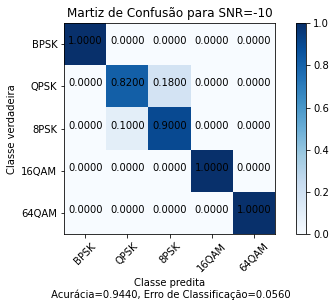

<Figure size 432x288 with 0 Axes>

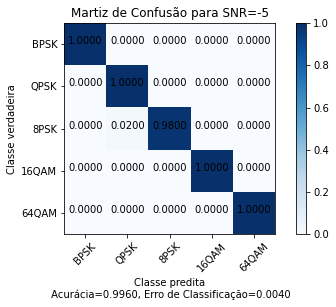

<Figure size 432x288 with 0 Axes>

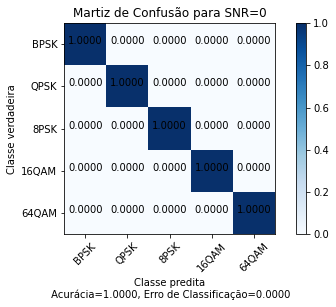

<Figure size 432x288 with 0 Axes>

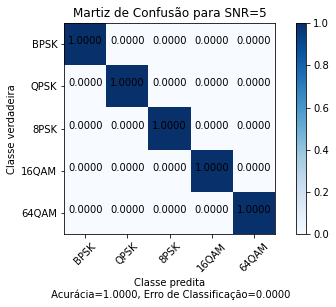

<Figure size 432x288 with 0 Axes>

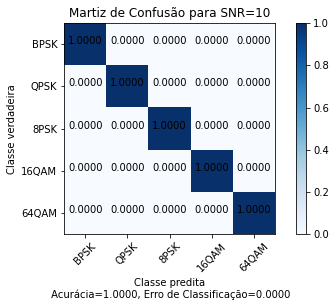

<Figure size 432x288 with 0 Axes>

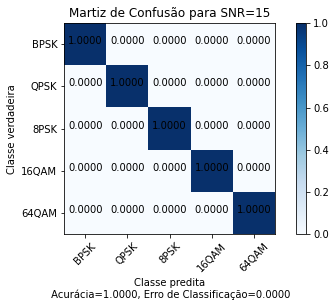

<Figure size 432x288 with 0 Axes>

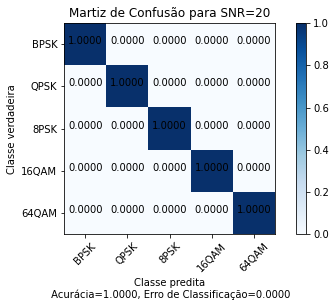

In [64]:
SNRs = list(range(-20,25,5))
acc = {}
idx = np.arange(0,len(test_data))
for snr in SNRs:
    test_SNRs = list(map(lambda x: test_snrs[x], idx))
    test_X_i = X[(np.where(np.array(test_SNRs)==snr))]
    test_Y_i = Y[(np.where(np.array(test_SNRs)==snr))]    
 

    test_Y_i_hat = model.predict(test_X_i)
    classes = ['BPSK', 'QPSK', '8PSK', '16QAM', '64QAM']
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1

    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    plt.figure()
    plot_confusion_matrix(confnorm, classes, title="Martiz de Confusão para SNR=%d"%(snr))
    plt.savefig(f"/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO_Canal_Real/{nTx}x{nRx}/{snr}.png", dpi=120, bbox_inches="tight")
    
 
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc[snr] = 1.0*cor/(cor+ncor)

In [65]:
txt = open(f"/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO_Canal_Real/{nTx}x{nRx}/acc_{nTx}_{nRx}.txt","w")
txt.write(str(acc))
txt.close()